## Generate large frames for testing

In [1]:
from Frame2D import Frame2D
from Frame2D.Tables import Table, DataSource
import numpy as np
import pandas as pd

In [2]:
## NOTE: all units are kN and m

FD = {'storey_heights': [6.5] + [5.5]*20 + [7.0],   # m
      'bay_widths': [10.5,10,10,10,10,10.5],        # m
      'frame_spacing':8,                            # m, used only for load calculation
      'specified_loads':{'live':2.4,'dead':4.0,'snow':2.5,'wind':2.5},  # kPa
      'load_combinations':{'Case-2a':{'dead':1.25,'live':1.5,'snow':0.5},
                           'Case-2b':{'dead':1.25,'live':1.5,'wind':0.4},
                           'Case-3a':{'dead':1.25,'snow':1.5,'live':0.5},
                           'Case-3b':{'dead':1.25,'snow':1.5,'wind':0.4},
                           'Case-4a':{'dead':1.25,'wind':1.4,'live':0.5},
                           'Case-4b':{'dead':1.25,'wind':1.4,'snow':0.5},
                          },
      'load_combo':'Case-2b',
      'braced_bays':[0,2,3,5],
      'support_fixity': ['fx,fy']*7,
      'beam_size': 'W1000x222',
      'column_size': 'W360x216',
      }

SaveData = True
ShowResults = True

In [3]:
FD

{'bay_widths': [10.5, 10, 10, 10, 10, 10.5],
 'beam_size': 'W1000x222',
 'braced_bays': [0, 2, 3, 5],
 'column_size': 'W360x216',
 'frame_spacing': 8,
 'load_combinations': {'Case-2a': {'dead': 1.25, 'live': 1.5, 'snow': 0.5},
  'Case-2b': {'dead': 1.25, 'live': 1.5, 'wind': 0.4},
  'Case-3a': {'dead': 1.25, 'live': 0.5, 'snow': 1.5},
  'Case-3b': {'dead': 1.25, 'snow': 1.5, 'wind': 0.4},
  'Case-4a': {'dead': 1.25, 'live': 0.5, 'wind': 1.4},
  'Case-4b': {'dead': 1.25, 'snow': 0.5, 'wind': 1.4}},
 'load_combo': 'Case-2b',
 'specified_loads': {'dead': 4.0, 'live': 2.4, 'snow': 2.5, 'wind': 2.5},
 'storey_heights': [6.5,
  5.5,
  5.5,
  5.5,
  5.5,
  5.5,
  5.5,
  5.5,
  5.5,
  5.5,
  5.5,
  5.5,
  5.5,
  5.5,
  5.5,
  5.5,
  5.5,
  5.5,
  5.5,
  5.5,
  5.5,
  7.0],
 'support_fixity': ['fx,fy',
  'fx,fy',
  'fx,fy',
  'fx,fy',
  'fx,fy',
  'fx,fy',
  'fx,fy']}

In [4]:
def genframe(fd):
    h = fd['storey_heights']
    w = fd['bay_widths']
    s = fd['frame_spacing']
    nnodes = (len(h)+1)*(len(w)+1)
    
    # names of column stacks and floor levels
    bayline = [chr(ord('A')+i) for i in range(len(w)+1)]
    floorlev = [str(i) for i in range(len(h)+1)]
    
    # generate the nodes
    nodelist = []
    nidgrid = np.ndarray((len(h)+1,len(w)+1),dtype=np.object)
    for i in range(len(h)+1):
        y = sum(h[:i])*1000.
        for j in range(len(w)+1):
            x = sum(w[:j])*1000.
            nid = bayline[j]+floorlev[i]
            nodelist.append((nid,x,y))
            nidgrid[i,j] = nid
    nodes = pd.DataFrame(nodelist,columns=['NODEID','X','Y'])
    
    # generate the supports
    assert len(fd['support_fixity'])==nidgrid.shape[1]
    supplist = []
    for j,s in enumerate(fd['support_fixity']):
        nid = nidgrid[0,j]
        fix = s.strip().upper().split(',')
        if len(fix) < 3:
            fix += [np.nan] * (3-len(fix))
        supplist.append([nid,]+fix)
    supports = pd.DataFrame(supplist,columns=['NODEID','C0','C1','C2'])
    
    # generate columns
    columns = []
    for i in range(nidgrid.shape[0]-1):
        for j in range(nidgrid.shape[1]):
            nidj = nidgrid[i,j]
            nidk = nidgrid[i+1,j]
            mid = 'C' + nidj + nidk
            columns.append((mid,nidj,nidk))
    
    # generate beams
    beams = []
    roofbeams = []
    pinnedbeams = []
    for i in range(1,nidgrid.shape[0]):
        beamlist = beams if i < nidgrid.shape[0]-1 else roofbeams
        for j in range(nidgrid.shape[1]-1):
            nidj = nidgrid[i,j]
            nidk = nidgrid[i,j+1]
            mid = 'B' + nidj + nidk
            beamlist.append((mid,nidj,nidk))
            if j not in fd['braced_bays']:
                pinnedbeams.append(mid)
    members = pd.DataFrame(columns+beams+roofbeams,columns=['MEMBERID','NODEJ','NODEK'])
    
    # generate releases
    rellist = []
    for mid in pinnedbeams:
        rellist.append((mid,'MZJ'))
        rellist.append((mid,'MZK'))
    releases = pd.DataFrame(rellist,columns=['MEMBERID','RELEASE'])
    
    # generate properties
    proplist = []
    size = fd['column_size']
    for mid,j,k in columns:
        proplist.append((mid,size,np.nan,np.nan))
        size = np.nan
    size = fd['beam_size']
    for mid,j,k in beams+roofbeams:
        proplist.append((mid,size,np.nan,np.nan))
        size = np.nan
    properties = pd.DataFrame(proplist,columns=['MEMBERID','SIZE','IX','A'])
    
    # generate node loads (wind from left)
    nloadlist = []
    L = fd['specified_loads']   # area loads
    for i in range(1,nidgrid.shape[0]+1):
        H = (sum(h[:i+1])-sum(h[:i-1]))/2.
        FL = H*fd['frame_spacing']*L['wind']
        if FL != 0.:
            nloadlist.append(('wind',nidgrid[i,0],'FX',FL*1000.))
    node_loads = pd.DataFrame(nloadlist,columns=['LOAD','NODEID','DIRN','F'])
    
    # generate member loads
    mloadlist = []
    UDL = -L['dead']*fd['frame_spacing']
    mloadlist += [('dead',mid,'UDL',UDL,np.nan,np.nan,np.nan,np.nan) for mid,nj,nk in beams]
    mloadlist += [('dead',mid,'UDL',UDL,np.nan,np.nan,np.nan,np.nan) for mid,nj,nk in roofbeams]
    UDL = -L['live']*fd['frame_spacing']
    mloadlist += [('live',mid,'UDL',UDL,np.nan,np.nan,np.nan,np.nan) for mid,nj,nk in beams]
    UDL = -L['snow']*fd['frame_spacing']
    mloadlist += [('snow',mid,'UDL',UDL,np.nan,np.nan,np.nan,np.nan) for mid,nj,nk in roofbeams]
    member_loads = pd.DataFrame(mloadlist,columns='LOAD,MEMBERID,TYPE,W1,W2,A,B,C'.split(','))
    
    # generate load combinations
    lclist = []
    for case,loads in fd['load_combinations'].items():
        for load,factor in loads.items():
            lclist.append((case,load,factor))
    load_combinations = pd.DataFrame(lclist,columns=['CASE','LOAD','FACTOR'])
    
    ds = DataSource
    ds.set_source(None)
    ds.set_table('nodes',nodes)
    ds.set_table('supports',supports)
    ds.set_table('members',members)
    ds.set_table('releases',releases)
    ds.set_table('properties',properties)
    ds.set_table('node_loads',node_loads)
    ds.set_table('member_loads',member_loads)
    ds.set_table('load_combinations',load_combinations)
    
    frame = Frame2D()
    frame.input_all()
    
    return frame

In [5]:
%time f = genframe(FD)

CPU times: user 308 ms, sys: 0 ns, total: 308 ms
Wall time: 309 ms


In [6]:
if SaveData:
    NS = len(FD['storey_heights'])
    NB = len(FD['bay_widths'])
    name = 'l{}x{}'.format(NS,NB)
    f.write_all(name,makedir=True)

In [7]:
%time rs = f.solve(FD['load_combo'])
if ShowResults:
    f.print_input()

CPU times: user 76 ms, sys: 4 ms, total: 80 ms
Wall time: 77.7 ms

Frame None:


              # of nodal degrees of freedom: 483
  # of constrained nodal degrees of freedom: 14
# of unconstrained nodal degrees of freedom: 469  (= degree of kinematic indeterminacy)

                               # of members: 286
                             # of reactions: 14
                                 # of nodes: 161
                            # of conditions: 88
           degree of statical indeterminacy: 301



Nodes:

Node          X         Y  Constraints  DOF #s
----      -----     -----  -----------  ------
A0            0         0  FX,FY        469,470,0
B0        10500         0  FX,FY        471,472,1
C0        20500         0  FX,FY        473,474,2
D0        30500         0  FX,FY        475,476,3
E0        40500         0  FX,FY        477,478,4
F0        50500         0  FX,FY        479,480,5
G0        61000         0  FX,FY        481,482,6
A1            0      6500          

In [8]:
if ShowResults:
    f.print_results(rs)


Results for load case: Case-2b
++++++++++++++++++++++++++++++


Node Displacements:

Node        DX         DY      Rotation
----      ------     ------   ---------
A0         0.000      0.000  -0.0219656
B0         0.000      0.000  -0.0237305
C0         0.000      0.000  -0.0222471
D0         0.000      0.000  -0.0239579
E0         0.000      0.000  -0.0234527
F0         0.000      0.000  -0.0223183
G0         0.000      0.000  -0.0240908
A1       105.817     -9.646  -0.0049075
B1       105.908    -17.455  -0.0014196
C1       105.927    -15.299  -0.0043953
D1       106.068    -18.206  -0.0010386
E1       106.128    -18.948  -0.0020765
F1       106.136    -14.088  -0.0043490
G1       106.265    -13.012  -0.0008639
A2       131.425    -17.662  -0.0037689
B2       131.359    -31.307  -0.0011586
C2       131.345    -27.795  -0.0030214
D2       131.322    -32.833  -0.0010502
E2       131.348    -34.150  -0.0009581
F2       131.368    -25.546  -0.0028531
G2       131.360    -23.423  -0.00

In [9]:
if SaveData:
    f.write_results(name,rs)

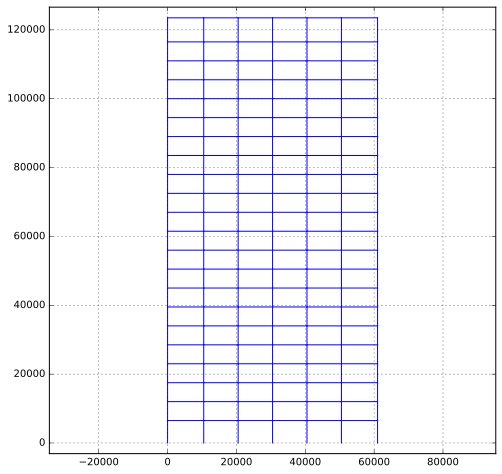

In [10]:
%matplotlib inline
f.show()